# Case Study

## Author: Drew Afromsky || daa2162@columbia.edu

**This notebook was created in a Kaggle kernel, with all necessary libraries/packages available and GPU access if needed**

## Abstract: 

The notebook begins by reading in the .txt file, which contains 530 rows and 16,562 columns. Upon first inspection, the data appears to be very sparse and since there are thousands of columns (features) it also appears that the data may have been one-hot encoded. This leads me to believe that the data is or is mimicking text data/medical EHR data, clinical trial data, or genetic data to some capacity. Column values are all binary and there does not appear to be any missing values in any of the rows. Looking further, there exists a **class imbalance** - there are many more negative class instances than positive instances (more than triple). This is addressed in the notebook by applying **various sampling techniques (oversample, undersample, class weighting, and SMOTE)**. Due to time and computational restraints a select few machine learning models were chosen for assessing the data and predict the 'response'. These models include **SVC, Decision Trees, Random Forests, XGBoost, Gradient Boosting, MLP, and Neural Netowork.**

## Machine Learning Model Selection

1. **Default Params, Unbalanced Data, No Cross-Validation (Baseline Model):** I begin by creating baseline machine learning models where the hyperparameters are their default values and with the class imbalance. This is important because it gives an idea of how well the models do without adjusting any parameters and allows one to look back and see if hyperparameter adjustments were helpful and improved performance.  <br />


2. **Default Params, Unbalanced Data, 3-Fold Cross-Validation:** The same criteria (default parameters, unbalanced) is used with the addition of stratified 3-fold cross validation. Cross-validation has the benefit of being able to train on different subsets of the data and validate the models on different validation sets of the data.  The folds are made by preserving the percentage of samples for each class. It is also a popular technique to avoid overfitting and is common when datasets are limited in size.  <br />


3. **GridSearchCV/Hyperparameter Tuning, Unbalanced Data, No Cross-Validation** (Same as 1., but with hyperparameter tuning)  <br />


4. **GridSearchCV/Hyperparameter Tuning, Unbalanced Data, Stratified 3-Fold Cross-Validation** (Same as 5., but with stratified 3-fold cross-validation) <br />


5. **Undersampling (default and GridSearch):** undersample the majority class so that it has the same size as the minority class; sampling without replacement <br />


6. **Oversampling (default and GridSearch)** repeat samples from the minority class randomly to match the size of the majority class <br />


7. **Class-Weighting (default and GridSearch)** re-weighting the loss function; same effect as over-sampling (though not random), but not as expensive (dataset size remains the same). <br />


8. **SMOTE - Synthetic Minority Over-Sampling Technique (default and GridSearch)** add synthetic data to the undersampled class to help bias the classifier to the smaller class <br />


## Binary Classification Evaluation Metrics
### **Source: https://developers.google.com/machine-learning/glossary**

#### Figures

1. **Precision-Recall Curves** A curve of precision vs. recall at different classification thresholds. <br />


2. **ROC Curves** A curve of true positive rate vs. false positive rate at different classification thresholds. <br />


3. **Confusion Matrix** An NxN table that summarizes how successful a classification model's predictions were; that is, the correlation between the label and the model's classification. One axis of a confusion matrix is the label that the model predicted, and the other axis is the actual label. N represents the number of classes. In a binary classification problem, N=2. Confusion matrices contain sufficient information to calculate a variety of performance metrics, including precision and recall. <br />


#### Performance Metrics

1. **Average Precision:** A metric for summarizing the performance of a ranked sequence of results. Average precision is calculated by taking the average of the precision values for each relevant result (each result in the ranked list where the recall increases relative to the previous result). <br />


2. **f1-score:** Harmonic mean of precision and recall. F-1 = 2 * (precision * recall) / (precision + recall). Source: https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score <br />


3. **ROC-AUC:** An evaluation metric that considers all possible classification thresholds. The Area Under the ROC curve is the probability that a classifier will be more confident that a randomly chosen positive example is actually positive than that a randomly chosen negative example is positive. <br />


4. **Precision:** A metric for classification models. Precision identifies the frequency with which a model was correct when predicting the positive class. Precision = TP / (TP + FP) <br />


5. **Recall:** A metric for classification models that answers the following question: Out of all the possible positive labels, how many did the model correctly identify? Recall = TP / (TP + FN) <br />


6. **Accuracy:** The fraction of predictions that a classification model got right. In binary classification, accuracy has the following definition: Acc = (TP + TN) / (Total # of Examples) <br />


7. **True Positive (TP), False Positive (FP), True Negative (TN), False Negatve (FN):** 
TP: An example in which the model correctly predicted the positive class. FP: An example in which the model mistakenly predicted the positive class; TN: An example in which the model correctly predicted the negative class; FN: An example in which the model mistakenly predicted the negative class. <br />



## Choosing the Best Model

In choosing the best model for this binary classification problem we would need to know the context of the dataset at hand. This is because there exists asymmetric costs and asymmetrical data. Even if the probability of class 0 and class 1 are the same, they might have different business costs or health costs or any other kind of cost-benefit associated with making different kinds of mistakes. Asymetrical data simply describes the situation in which one class is much more common than the other class.

Choosing the best model relies on looking at the associated model's performance/evaluation metrics. Ideally we could take into account symmetric costs, however, the context of the data is not known. For instance, we may value precision over recall or vice versa depending on the effect of type I/II errors. We can then evaluate a model based on its precision-recall tradeoff, interpretability, run-time/inference capability, etc. However, across nearly all models it is apparent that overfitting has occurred, especially with the neural network model, as is visible with the ROC curves. This is likely due to there being very few training examples.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pylab as pyl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from tensorflow.keras import layers
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, r2_score, roc_auc_score, average_precision_score
from tensorflow import feature_column
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import matplotlib as mpl
from sklearn import svm
import seaborn as sns
from tqdm import tqdm
import itertools
import tempfile
import sklearn
import glob
import re
import os

Using TensorFlow backend.


In [2]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.1.0
Hub version: 0.7.0
GPU is NOT AVAILABLE


In [3]:
# Get current working directory
os.getcwd()

'/kaggle/working'

In [4]:
# Move up a directory
%cd ..

/kaggle


In [5]:
# Change to the directory with the .txt data
os.chdir("/kaggle/input")

In [6]:
# Print working directory to make sure we are in the right location
print(os.getcwd())

/kaggle/input


In [7]:
# Display the files in the current working directory
os.listdir()

['DScasestudy_(1).txt']

In [8]:
# Read the data (.txt file and create dataframe with features/predictors and response/labels)
text = pd.read_csv("DScasestudy_(1).txt", delimiter = "\t")
df = pd.DataFrame(data = text)
df

,response,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
526,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
527,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
528,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [9]:
# df.dtypes

In [10]:
# df.describe()

In [11]:
neg, pos = np.bincount(df['response'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n     Negative: {} ({:.2f}% of total)'.format(total, pos, 100 * pos / total, neg, 100 * neg / total))

Examples:
    Total: 530
    Positive: 123 (23.21% of total)
     Negative: 407 (76.79% of total)


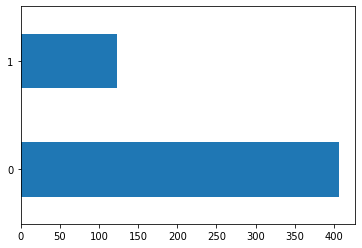

In [12]:
df['response'].value_counts().plot(kind='barh')
plt.show()

In [13]:
# Look for missing values in each column of the dataframe
# If emp_list is empty then there are no missing items
# Otherwise, alter the code to track where the missing 
# items came from and either replace/interpolate or remove

emp_list = []

for (columnName, columnData) in df.iteritems():
#     print('Colunm Name : ', columnName)
#     print('Column Contents : ', columnData.values)
    bools = pd.isnull(np.array(df['{}'.format(columnName)]))
    for e in bools:
        if e == True:
            emp_list.append(columnName)

In [14]:
# Check to see if any missing values were detected
# zero means no column had any missing values
len(emp_list)

0

In [15]:
# Separate into features and labels
y = df.pop('response')
X = df
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
526,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
527,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
528,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [16]:
y

0      1
1      1
2      1
3      1
4      1
      ..
525    0
526    0
527    0
528    0
529    0
Name: response, Length: 530, dtype: int64

# Baseline Models (default parameters & unbalanced)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
scoring = 'f1'

In [18]:
def stat_printer(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    metrics = ['F1 Score', 'Recall', 'Precision', 'Accuracy', 'AUC ROC']
    scores = [f1, recall, precision, accuracy, auc_roc]
    stat_df = pd.DataFrame(list(zip(metrics, scores)), columns =['Metric', 'Score']) 
    display(stat_df)
    return None

In [19]:
def roc_maker(arch_str, y_pred, y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
    plt.legend(loc=4)
    plt.title(arch_str + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Tue Positive Rate')
    plt.show()
    return None

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

In [21]:
def preliminary_testing(X, y, i):
    
    # Train test split with stratification of labels
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Initialize lists to hold models and metrics
    premodels = []
    model_names = []
    f1_scores = []
    recalls = []
    precisions = []
    average_precisions = []
    accuracies = []
    auc = []
    
    # Initialize and add models to premodels list
#     premodels.append(('K-NearestNeighbors', KNeighborsClassifier()))
    premodels.append(('SVC', SVC()))
#     premodels.append(('LogisticRegression', LogisticRegression()))
    premodels.append(('DecisionTree', DecisionTreeClassifier()))
#     premodels.append(('GaussianNaiveBayes', GaussianNB()))
    premodels.append(('RandomForest', RandomForestClassifier()))
    premodels.append(('XGBoost', XGBClassifier()))
    premodels.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    premodels.append(('MLPClassifier', MLPClassifier()))
    
    # Iteratively call each model and append metrics to corresponding lists
    for name, premodel in premodels:
        premodel.fit(X_train, y_train)
        y_pred = premodel.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred, average='binary'))
        recalls.append(recall_score(y_test, y_pred, average='binary'))
        average_precisions.append(average_precision_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='binary'))
        auc.append(roc_auc_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))
        model_names.append(name)
        
    # Make dataframe of each model's performance and return it    
    preliminary_test = pd.DataFrame({'Model Name': model_names, 'F1-Score': f1_scores, 'Recall':recalls, 'Average Precision': average_precisions, 
                                     'Precision':precisions, 'Accuracy':accuracies, 'AUC-ROC':auc})
    return preliminary_test

In [22]:
# Now, we will do preliminary model testing. This a good approach to take that enables one to determine which 
# models may be best to use for any application. Although, we are only attempting to see how our models 
# perform, this is useful to perform before optimizing moving forward.

splits = [.1, .2, .3]
for i in splits:
    prelims = preliminary_testing(X, y, i)
    print("With a training size of {}%, we get the following results".format((1-i)*100))
    display(prelims)
    print("_"*80 + '\n')

With a training size of 90.0%, we get the following results


,Model Name,F1-Score,Recall,Average Precision,Precision,Accuracy,AUC-ROC
0,SVC,0.347826,0.210526,0.398026,1.000000,0.8125,0.605263
1,DecisionTree,0.650000,0.684211,0.498559,0.619048,0.8250,0.776531
2,RandomForest,0.689655,0.526316,0.638816,1.000000,0.8875,0.763158
3,XGBoost,0.812500,0.684211,0.759211,1.000000,0.9250,0.842105
4,GradientBoostingClassifier,0.812500,0.684211,0.759211,1.000000,0.9250,0.842105
5,MLPClassifier,0.689655,0.526316,0.638816,1.000000,0.8875,0.763158


________________________________________________________________________________

With a training size of 80.0%, we get the following results


,Model Name,F1-Score,Recall,Average Precision,Precision,Accuracy,AUC-ROC
0,SVC,0.347826,0.210526,0.398026,1.000000,0.8125,0.605263
1,DecisionTree,0.684211,0.684211,0.543144,0.684211,0.8500,0.792925
2,RandomForest,0.774194,0.631579,0.719079,1.000000,0.9125,0.815789
3,XGBoost,0.812500,0.684211,0.759211,1.000000,0.9250,0.842105
4,GradientBoostingClassifier,0.787879,0.684211,0.710338,0.928571,0.9125,0.833909
5,MLPClassifier,0.689655,0.526316,0.638816,1.000000,0.8875,0.763158


________________________________________________________________________________

With a training size of 70.0%, we get the following results


,Model Name,F1-Score,Recall,Average Precision,Precision,Accuracy,AUC-ROC
0,SVC,0.347826,0.210526,0.398026,1.000000,0.8125,0.605263
1,DecisionTree,0.684211,0.684211,0.543144,0.684211,0.8500,0.792925
2,RandomForest,0.689655,0.526316,0.638816,1.000000,0.8875,0.763158
3,XGBoost,0.812500,0.684211,0.759211,1.000000,0.9250,0.842105
4,GradientBoostingClassifier,0.812500,0.684211,0.759211,1.000000,0.9250,0.842105
5,MLPClassifier,0.689655,0.526316,0.638816,1.000000,0.8875,0.763158


________________________________________________________________________________



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

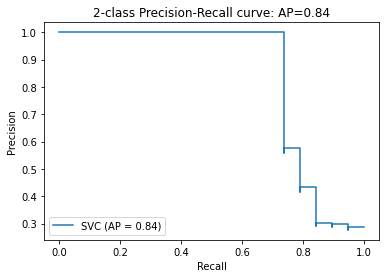

In [23]:
classifier = SVC()
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test) #test_features

average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl

disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

### We can see that precision is steady at 1.0 then dips drastically at a recall of ~0.48/0.49 and then remains steady precision then dips again and this pattern continues. 

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.50')

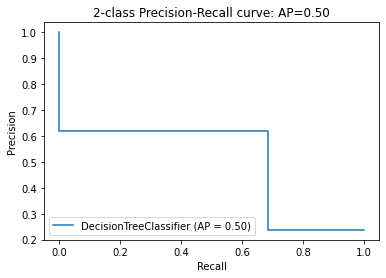

In [24]:
classifier_dt = DecisionTreeClassifier()
classifier_dt.fit(X_train, y_train)
y_score_dt = classifier_dt.predict_proba(X_test)[:,1] #test_features

average_precision_dt = average_precision_score(y_test, y_score_dt) # y_test might be test_labesl

disp_dt = plot_precision_recall_curve(classifier_dt, X_test, y_test) #test_features, test_labels
disp_dt.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_dt))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

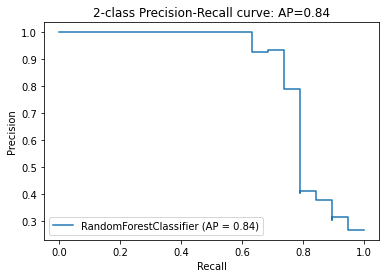

In [25]:
classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:,1] #test_features

average_precision_rf = average_precision_score(y_test, y_score_rf) # y_test might be test_labesl

disp_rf = plot_precision_recall_curve(classifier_rf, X_test, y_test) #test_features, test_labels
disp_rf.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_rf))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

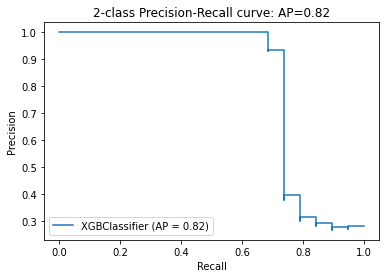

In [26]:
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)
y_score_xgb = classifier_xgb.predict_proba(X_test)[:,1] #test_features

average_precision_xgb = average_precision_score(y_test, y_score_xgb) # y_test might be test_labesl

disp_xgb = plot_precision_recall_curve(classifier_xgb, X_test, y_test) #test_features, test_labels
disp_xgb.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_xgb))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.79')

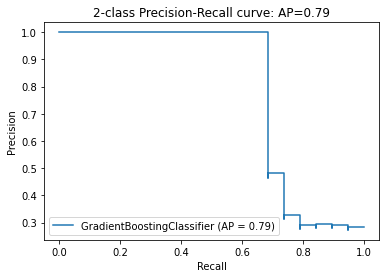

In [27]:
classifier_gb = GradientBoostingClassifier()
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:,1] #test_features

average_precision_gb = average_precision_score(y_test, y_score_gb) # y_test might be test_labesl

disp_gb = plot_precision_recall_curve(classifier_gb, X_test, y_test) #test_features, test_labels
disp_gb.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_gb))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

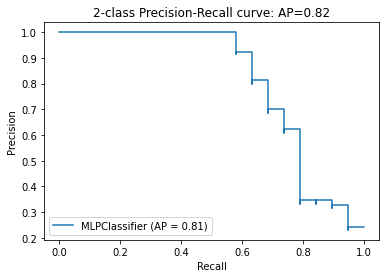

In [28]:
classifier_mlp = MLPClassifier()
classifier_mlp.fit(X_train, y_train)
y_score_mlp = classifier_xgb.predict_proba(X_test)[:,1] #test_features

average_precision_mlp = average_precision_score(y_test, y_score_mlp) # y_test might be test_labesl

disp_mlp = plot_precision_recall_curve(classifier_mlp, X_test, y_test) #test_features, test_labels
disp_mlp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision_mlp))

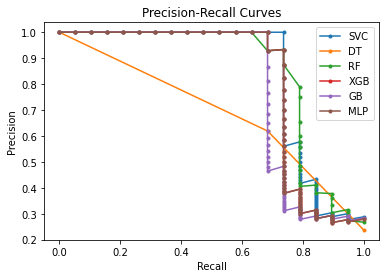

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_score_dt)
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_score_xgb)
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, y_score_gb)
precision_mlp, recall_mlp, thresholds_mlp = precision_recall_curve(y_test, y_score_mlp)

plt.plot(recall, precision, marker='.', label='SVC')
plt.plot(recall_dt, precision_dt, marker='.', label='DT')
plt.plot(recall_rf, precision_rf, marker='.', label='RF')
plt.plot(recall_xgb, precision_xgb, marker='.', label='XGB')
plt.plot(recall_gb, precision_gb, marker='.', label='GB')
plt.plot(recall_mlp, precision_mlp, marker='.', label='MLP')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curves")
# show the legend
plt.legend()
# show the plot
plt.show()

# Default Params & Unbalanced with Stratified 3-Fold Cross-Validation

In [30]:
####################################
#####      SVC Classifier      ##### 
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_svc_cv_base = cross_validate(SVC(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_svc_cv_base)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.789539
test_average_precision    0.686603
test_f1                   0.108187
dtype: float64

In [31]:
####################################
##### Decision Tree Classifier ##### 
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_dt = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_dt)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.708177
test_average_precision    0.408013
test_f1                   0.551284
dtype: float64

In [32]:
####################################
##### Random Forest Classifier ##### 
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_rf = cross_validate(RandomForestClassifier(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_rf)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.784195
test_average_precision    0.682023
test_f1                   0.496085
dtype: float64

In [33]:
####################################
#####    XGBoost Classifier    ##### 
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_xgb = cross_validate(XGBClassifier(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_xgb)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.805944
test_average_precision    0.728845
test_f1                   0.662537
dtype: float64

In [34]:
########################################
##### Gradient Boosting Classifier ##### 
########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_gb = cross_validate(GradientBoostingClassifier(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_gb)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.772678
test_average_precision    0.703979
test_f1                   0.659883
dtype: float64

In [35]:
####################################
#####      MLP Classifier      ##### 
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_mlp = cross_validate(MLPClassifier(), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_mlp)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


test_roc_auc              0.781569
test_average_precision    0.665544
test_f1                   0.357426
dtype: float64

# Grid Search with Unbalanced Dataset

In [36]:
scoring = 'f1'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify= y)




The best parameters: {'C': 1.0, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.01}



,Metric,Score
0,F1 Score,0.684211
1,Recall,0.684211
2,Precision,0.684211
3,Accuracy,0.850000
4,AUC ROC,0.792925




True Negatives:  55
False Positives:  6
False Negatives:  6
True Positives:  13
Total:  19




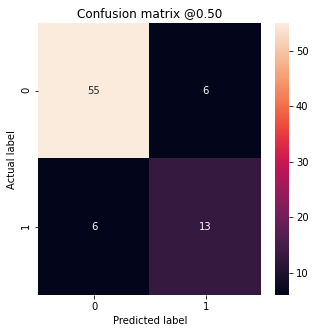

In [37]:
####################################################################
####################                            ####################
####################      SVC GridSearchCV      ####################
####################                            ####################
####################################################################

# Parameter grid
param_grid = {
        'C':[1.0],
        'kernel': ['linear', 'rbf'],
        'degree':[2, 3],
        'gamma': ['scale', 'auto'], #auto_deprecated
        'tol': [.01, .001, .0001],
        'class_weight': ['balanced'],
        'decision_function_shape': ['ovr'],
#         'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(SVC(), param_grid = param_grid, cv = 3, scoring = scoring)

# Train/fit the model
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)

# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(svc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,svc_pred)
print("\n")

ROC Curve for the SVC


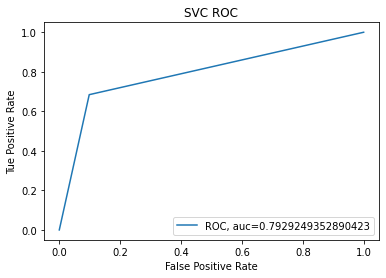

In [38]:
# ROC Curve
print('ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)




The best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 2.0, 'min_samples_leaf': 0.3, 'min_samples_split': 0.3, 'min_weight_fraction_leaf': 0.3, 'splitter': 'best'}



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Score
0,F1 Score,0.0000
1,Recall,0.0000
2,Precision,0.0000
3,Accuracy,0.7625
4,AUC ROC,0.5000




True Negatives:  61
False Positives:  0
False Negatives:  19
True Positives:  0
Total:  19




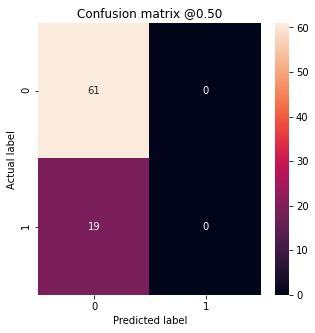

In [39]:
##############################################################################
####################                                      ####################
####################      Decision Tree GridSearchCV      ####################
####################                                      ####################
##############################################################################

# Parameter grid
param_grid = {
        'criterion':['gini', 'entropy'],
        'splitter': ['best'],
        'max_depth': [5, 7, None],
        'min_samples_split':[0.3, 0.4],
        'min_samples_leaf': [0.3, 0.4],
        'min_weight_fraction_leaf':[0.3, 0.4],
#         'max_features': ['auto', 'sqrt', 'log2'],
        'max_features': ['auto', 'sqrt'],
        'min_impurity_decrease' :[2.0, 3.0],
        }

# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=3, scoring = scoring)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)

# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(dtc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,dtc_pred)
print("\n")

ROC Curve for the Decision Tree Classifier


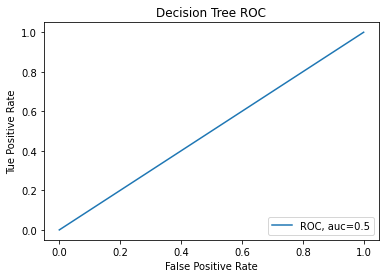

In [40]:
# ROC Curve
print('ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree', dtc_pred, y_test)

In [41]:
####################################################################
####################                            ####################
####################      XGB GridSearchCV      ####################
####################                            ####################
####################################################################

data = xgb.DMatrix(data=X_train, label=y_train)

xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
#     "early_stopping_rounds": 10,
    "seed": 4060
}

xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)

cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=3, callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(500)])

[0]	train-error:0.76889	test-error:0.76889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 500 rounds.
[1]	train-error:0.76889	test-error:0.76889
[2]	train-error:0.76889	test-error:0.76889
[3]	train-error:0.76889	test-error:0.76889
[4]	train-error:0.76889	test-error:0.76889
[5]	train-error:0.25333	test-error:0.42222
[6]	train-error:0.20333	test-error:0.36222
[7]	train-error:0.09111	test-error:0.24000
[8]	train-error:0.07333	test-error:0.20667
[9]	train-error:0.05444	test-error:0.17556
[10]	train-error:0.04667	test-error:0.16889
[11]	train-error:0.04889	test-error:0.16000
[12]	train-error:0.04556	test-error:0.15778
[13]	train-error:0.04778	test-error:0.15111
[14]	train-error:0.04889	test-error:0.14222
[15]	train-error:0.04778	test-error:0.14000
[16]	train-error:0.05000	test-error:0.14889
[17]	train-error:0.05000	test-error:0.13333
[18]	train-error:0.04889	test-error:0.14000
[19]	train-error:0.04889	tes

[182]	train-error:0.00000	test-error:0.16444
[183]	train-error:0.00000	test-error:0.15778
[184]	train-error:0.00000	test-error:0.16222
[185]	train-error:0.00000	test-error:0.15778
[186]	train-error:0.00000	test-error:0.15778
[187]	train-error:0.00000	test-error:0.16222
[188]	train-error:0.00000	test-error:0.16000
[189]	train-error:0.00000	test-error:0.16222
[190]	train-error:0.00000	test-error:0.16444
[191]	train-error:0.00000	test-error:0.16000
[192]	train-error:0.00000	test-error:0.16000
[193]	train-error:0.00000	test-error:0.16222
[194]	train-error:0.00000	test-error:0.16000
[195]	train-error:0.00000	test-error:0.16000
[196]	train-error:0.00000	test-error:0.16000
[197]	train-error:0.00000	test-error:0.16667
[198]	train-error:0.00000	test-error:0.16000
[199]	train-error:0.00000	test-error:0.16444
[200]	train-error:0.00000	test-error:0.15778
[201]	train-error:0.00000	test-error:0.16444
[202]	train-error:0.00000	test-error:0.16222
[203]	train-error:0.00000	test-error:0.17111
[204]	trai

[365]	train-error:0.00000	test-error:0.16222
[366]	train-error:0.00000	test-error:0.15556
[367]	train-error:0.00000	test-error:0.16444
[368]	train-error:0.00000	test-error:0.15556
[369]	train-error:0.00000	test-error:0.15556
[370]	train-error:0.00000	test-error:0.15333
[371]	train-error:0.00000	test-error:0.16000
[372]	train-error:0.00000	test-error:0.15556
[373]	train-error:0.00000	test-error:0.15778
[374]	train-error:0.00000	test-error:0.15778
[375]	train-error:0.00000	test-error:0.16000
[376]	train-error:0.00000	test-error:0.15556
[377]	train-error:0.00000	test-error:0.15778
[378]	train-error:0.00000	test-error:0.15778
[379]	train-error:0.00000	test-error:0.15778
[380]	train-error:0.00000	test-error:0.15556
[381]	train-error:0.00000	test-error:0.15556
[382]	train-error:0.00000	test-error:0.15778
[383]	train-error:0.00000	test-error:0.15556
[384]	train-error:0.00000	test-error:0.15556
[385]	train-error:0.00000	test-error:0.15556
[386]	train-error:0.00000	test-error:0.15778
[387]	trai

,Metric,Score
0,F1 Score,0.787879
1,Recall,0.684211
2,Precision,0.928571
3,Accuracy,0.912500
4,AUC ROC,0.833909




True Negatives:  60
False Positives:  1
False Negatives:  6
True Positives:  13
Total:  19




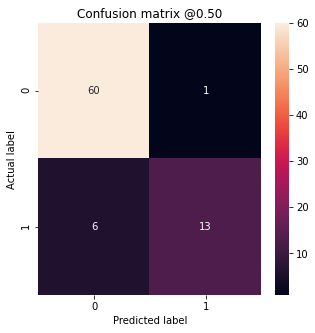

In [42]:
# Take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()

# Retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,xgb_pred)
print("\n")

ROC Curve for the XGBoost Classifier


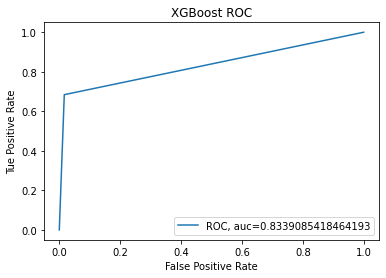

In [43]:
# ROC Curve
print('ROC Curve for the XGBoost Classifier')
roc_maker('XGBoost', xgb_pred, y_test)

# Addressing Class Imbalance with Various Sampling Methods

## 1. Random Undersampling

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
scoring = 'f1'

In [45]:
rus = RandomUnderSampler(replacement=False)

X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(450, 16562)
(208, 16562)
[104 104]


In [46]:
##########################################
##      SVC (Undersampled Dataset)      ##
#######      Defualt Params        #######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_svc = make_imb_pipeline(RandomUnderSampler(), SVC())

scores_svc_us = cross_validate(undersample_pipe_svc, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision', 'f1')) # Stratified K-Fold

pd.DataFrame(scores_svc_us)[['test_roc_auc', 'test_average_precision', 'test_f1']].mean()

test_roc_auc              0.769149
test_average_precision    0.618260
test_f1                   0.534575
dtype: float64

In [47]:
print(X_train.shape)

(450, 16562)





The best parameters: {'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear', 'svc__tol': 0.001}



,Metric,Score
0,F1 Score,0.612245
1,Recall,0.789474
2,Precision,0.500000
3,Accuracy,0.762500
4,AUC ROC,0.771786




True Negatives:  46
False Positives:  15
False Negatives:  4
True Positives:  15
Total:  19




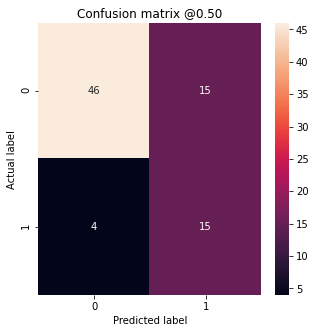

In [48]:
##########################################
##      SVC (Undersampled Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
#         'C':[1.0],
        'svc__kernel': ['linear', 'rbf'],
        'svc__degree':[2, 3],
        'svc__gamma': ['scale', 'auto'], #auto_deprecated
        'svc__tol': [.01, .001, .0001],
#         'class_weight': ['balanced'],
#         'decision_function_shape': ['ovr'],
#         'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(undersample_pipe_svc, param_grid = param_grid, cv = 3, scoring = scoring)

# Train/fit the model
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)

# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(svc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,svc_pred)
print("\n")

ROC Curve for the SVC


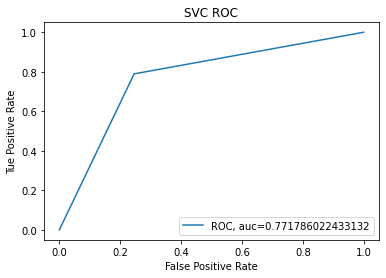

In [50]:
# ROC Curve
print('ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)

In [51]:
##########################################
## Decision Tree (Undersampled Dataset) ##
######      Default Params          ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_dt = make_imb_pipeline(RandomUnderSampler(), DecisionTreeClassifier())

scores_dt_us = cross_validate(undersample_pipe_dt, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_dt_us)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.664105
test_average_precision    0.330419
test_f1                   0.476909
dtype: float64




The best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_impurity_decrease': 2.0, 'decisiontreeclassifier__min_samples_leaf': 0.3, 'decisiontreeclassifier__splitter': 'best'}



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Score
0,F1 Score,0.0000
1,Recall,0.0000
2,Precision,0.0000
3,Accuracy,0.7625
4,AUC ROC,0.5000




True Negatives:  61
False Positives:  0
False Negatives:  19
True Positives:  0
Total:  19




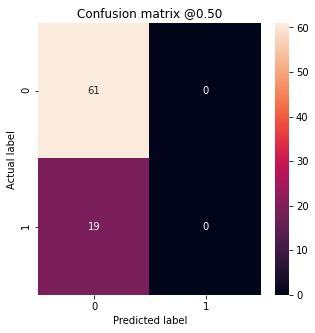

In [52]:
##########################################
## Decision Tree (Undersampled Dataset) ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
        'decisiontreeclassifier__criterion':['gini', 'entropy'],
        'decisiontreeclassifier__splitter': ['best'],
        'decisiontreeclassifier__max_depth': [5, 7, None],
#         'decisiontreeclassifier__min_samples_split':[0.3, 0.4],
        'decisiontreeclassifier__min_samples_leaf': [0.3, 0.4],
#         'decisiontreeclassifier__min_weight_fraction_leaf':[0.3, 0.4],
#         'max_features': ['auto', 'sqrt', 'log2'],
        'decisiontreeclassifier__max_features': ['auto', 'sqrt'],
        'decisiontreeclassifier__min_impurity_decrease' :[2.0, 3.0],
        }

# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(undersample_pipe_dt, param_grid=param_grid, cv=3, scoring = scoring)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)

# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,dtc_pred)
print("\n")

ROC Curve for the Decision Tree Classifier


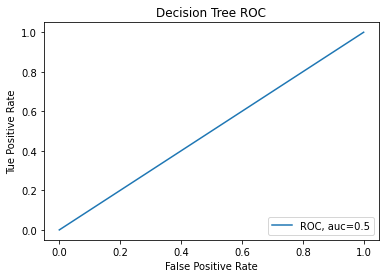

In [53]:
# ROC Curve
print('ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree', dtc_pred, y_test)

In [54]:
##########################################
## Random Forest (Undersampled Dataset) ##
#######      Defualt Params        #######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())

scores_rf_us = cross_validate(undersample_pipe_rf, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision', 'f1')) # Stratified K-Fold

pd.DataFrame(scores_rf_us)[['test_roc_auc', 'test_average_precision', 'test_f1']].mean()

test_roc_auc              0.789198
test_average_precision    0.613969
test_f1                   0.566341
dtype: float64

In [55]:
####################################
## XGBoost (Undersampled Dataset) ##
######    Default Params       #####
####################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_xgb = make_imb_pipeline(RandomUnderSampler(), XGBClassifier())

scores_xgb_us = cross_validate(undersample_pipe_xgb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_xgb_us)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.768771
test_average_precision    0.698289
test_f1                   0.557529
dtype: float64

In [56]:
##########################################
##      XGB (Undersampled Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

data = xgb.DMatrix(data=X_train, label=y_train)

xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
#     "early_stopping_rounds": 10,
    "seed": 4060
}

xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)

cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=3, callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(500)])

[0]	train-error:0.76889	test-error:0.76889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 500 rounds.
[1]	train-error:0.76889	test-error:0.76889
[2]	train-error:0.76889	test-error:0.76889
[3]	train-error:0.76889	test-error:0.76889
[4]	train-error:0.76889	test-error:0.76889
[5]	train-error:0.23222	test-error:0.39333
[6]	train-error:0.20111	test-error:0.37333
[7]	train-error:0.10000	test-error:0.23556
[8]	train-error:0.08556	test-error:0.24000
[9]	train-error:0.06222	test-error:0.18667
[10]	train-error:0.05556	test-error:0.16000
[11]	train-error:0.04667	test-error:0.13778
[12]	train-error:0.05222	test-error:0.14444
[13]	train-error:0.05000	test-error:0.13778
[14]	train-error:0.05000	test-error:0.12667
[15]	train-error:0.04778	test-error:0.12444
[16]	train-error:0.05222	test-error:0.12667
[17]	train-error:0.05000	test-error:0.12444
[18]	train-error:0.04889	test-error:0.12444
[19]	train-error:0.05000	tes

[182]	train-error:0.00000	test-error:0.16667
[183]	train-error:0.00000	test-error:0.16222
[184]	train-error:0.00000	test-error:0.16444
[185]	train-error:0.00000	test-error:0.16222
[186]	train-error:0.00000	test-error:0.16667
[187]	train-error:0.00000	test-error:0.16444
[188]	train-error:0.00000	test-error:0.16667
[189]	train-error:0.00000	test-error:0.16444
[190]	train-error:0.00000	test-error:0.16444
[191]	train-error:0.00000	test-error:0.16667
[192]	train-error:0.00000	test-error:0.16444
[193]	train-error:0.00000	test-error:0.16222
[194]	train-error:0.00000	test-error:0.16667
[195]	train-error:0.00000	test-error:0.16222
[196]	train-error:0.00000	test-error:0.16667
[197]	train-error:0.00000	test-error:0.16222
[198]	train-error:0.00000	test-error:0.16667
[199]	train-error:0.00000	test-error:0.16222
[200]	train-error:0.00000	test-error:0.16667
[201]	train-error:0.00000	test-error:0.16222
[202]	train-error:0.00000	test-error:0.16000
[203]	train-error:0.00000	test-error:0.16444
[204]	trai

[365]	train-error:0.00000	test-error:0.16222
[366]	train-error:0.00000	test-error:0.15333
[367]	train-error:0.00000	test-error:0.16222
[368]	train-error:0.00000	test-error:0.15778
[369]	train-error:0.00000	test-error:0.15556
[370]	train-error:0.00000	test-error:0.15556
[371]	train-error:0.00000	test-error:0.15778
[372]	train-error:0.00000	test-error:0.15333
[373]	train-error:0.00000	test-error:0.15778
[374]	train-error:0.00000	test-error:0.15333
[375]	train-error:0.00000	test-error:0.16222
[376]	train-error:0.00000	test-error:0.15333
[377]	train-error:0.00000	test-error:0.16222
[378]	train-error:0.00000	test-error:0.15333
[379]	train-error:0.00000	test-error:0.16222
[380]	train-error:0.00000	test-error:0.15556
[381]	train-error:0.00000	test-error:0.15778
[382]	train-error:0.00000	test-error:0.15556
[383]	train-error:0.00000	test-error:0.15778
[384]	train-error:0.00000	test-error:0.15556
[385]	train-error:0.00000	test-error:0.15778
[386]	train-error:0.00000	test-error:0.15556
[387]	trai

,Metric,Score
0,F1 Score,0.823529
1,Recall,0.736842
2,Precision,0.933333
3,Accuracy,0.925000
4,AUC ROC,0.860224




True Negatives:  60
False Positives:  1
False Negatives:  5
True Positives:  14
Total:  19




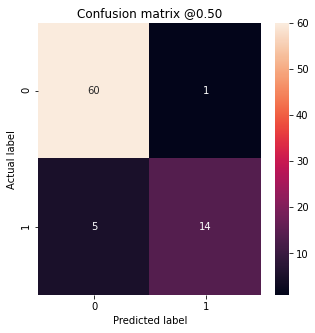

In [57]:
# Take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()

# Retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,xgb_pred)
print("\n")

ROC Curve for the XGBoost Classifier


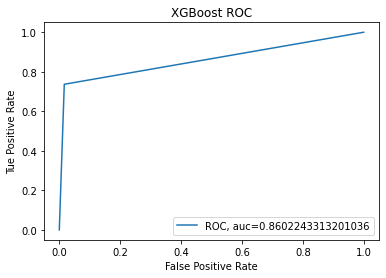

In [58]:
# ROC Curve
print('ROC Curve for the XGBoost Classifier')
roc_maker('XGBoost', xgb_pred, y_test)

In [59]:
##############################################
## Gradient Boosting (Undersampled Dataset) ##
#########       Default Params      ##########
##############################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_gb = make_imb_pipeline(RandomUnderSampler(), GradientBoostingClassifier())

scores_gb_us = cross_validate(undersample_pipe_gb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_gb_us)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.759342
test_average_precision    0.681603
test_f1                   0.529899
dtype: float64

In [62]:
################################
## MLP (Undersampled Dataset) ##
######   Default Params  #######
################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

undersample_pipe_mlp = make_imb_pipeline(RandomUnderSampler(), MLPClassifier())

scores_mlp_us = cross_validate(undersample_pipe_mlp, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_mlp_us)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.758614
test_average_precision    0.571979
test_f1                   0.492712
dtype: float64

## 2. Random Oversampling

In [63]:
ros = RandomOverSampler()

X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)

print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(450, 16562)
(692, 16562)
[346 346]


In [64]:
######################################
## SVC (Oversampled Dataset) ##
######################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_svc = make_imb_pipeline(RandomOverSampler(),SVC())

scores_svc_os = cross_validate(oversample_pipe_svc, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_svc_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.797644
test_average_precision    0.676449
test_f1                   0.506111
dtype: float64




The best parameters: {'svc__degree': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf', 'svc__tol': 0.01}



,Metric,Score
0,F1 Score,0.651163
1,Recall,0.736842
2,Precision,0.583333
3,Accuracy,0.812500
4,AUC ROC,0.786454




True Negatives:  51
False Positives:  10
False Negatives:  5
True Positives:  14
Total:  19




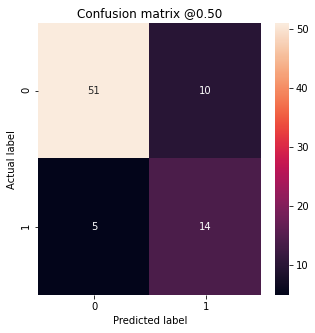

In [65]:
##########################################
##      SVC (Oversampled Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
#         'C':[1.0],
        'svc__kernel': ['linear', 'rbf'],
        'svc__degree':[2, 3],
        'svc__gamma': ['scale', 'auto'], #auto_deprecated
        'svc__tol': [.01, .001, .0001],
#         'class_weight': ['balanced'],
#         'decision_function_shape': ['ovr'],
#         'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(oversample_pipe_svc, param_grid = param_grid, cv = 3, scoring = scoring)

# Train/fit the model
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)

# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(svc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,svc_pred)
print("\n")

ROC Curve for the SVC


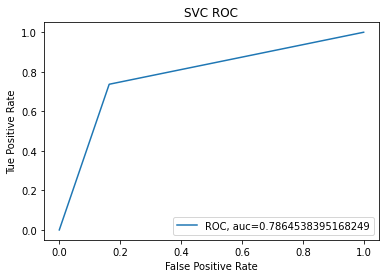

In [66]:
# ROC Curve
print('ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)

In [67]:
#########################################
## Decision Tree (Oversampled Dataset) ##
#########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_dt = make_imb_pipeline(RandomOverSampler(),DecisionTreeClassifier())

scores_dt_os = cross_validate(oversample_pipe_dt, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_dt_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.717274
test_average_precision    0.419902
test_f1                   0.564519
dtype: float64




The best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_impurity_decrease': 2.0, 'decisiontreeclassifier__min_samples_leaf': 0.3, 'decisiontreeclassifier__splitter': 'best'}



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Score
0,F1 Score,0.0000
1,Recall,0.0000
2,Precision,0.0000
3,Accuracy,0.7625
4,AUC ROC,0.5000




True Negatives:  61
False Positives:  0
False Negatives:  19
True Positives:  0
Total:  19




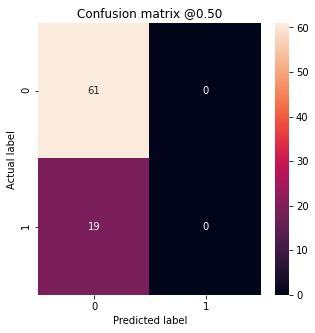

In [68]:
##########################################
## Decision Tree (Oversampled Dataset) ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
        'decisiontreeclassifier__criterion':['gini', 'entropy'],
        'decisiontreeclassifier__splitter': ['best'],
        'decisiontreeclassifier__max_depth': [5, 7, None],
#         'decisiontreeclassifier__min_samples_split':[0.3, 0.4],
        'decisiontreeclassifier__min_samples_leaf': [0.3, 0.4],
#         'decisiontreeclassifier__min_weight_fraction_leaf':[0.3, 0.4],
#         'max_features': ['auto', 'sqrt', 'log2'],
        'decisiontreeclassifier__max_features': ['auto', 'sqrt'],
        'decisiontreeclassifier__min_impurity_decrease' :[2.0, 3.0],
        }

# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(oversample_pipe_dt, param_grid=param_grid, cv=3, scoring = scoring)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)

# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,dtc_pred)
print("\n")

ROC Curve for the Decision Tree Classifier


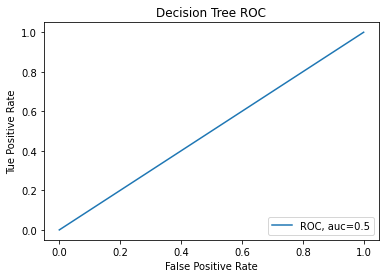

In [69]:
# ROC Curve
print('ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree', dtc_pred, y_test)

In [71]:
#########################################
## Random Forest (Oversampled Dataset) ##
#########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())

scores_rf_os = cross_validate(oversample_pipe_rf, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_rf_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.801997
test_average_precision    0.690236
test_f1                   0.553889
dtype: float64

In [72]:
###################################
## XGBoost (Oversampled Dataset) ##
###################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_xgb = make_imb_pipeline(RandomOverSampler(),XGBClassifier())

scores_xgb_os = cross_validate(oversample_pipe_xgb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_xgb_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.786956
test_average_precision    0.709438
test_f1                   0.636333
dtype: float64

In [73]:
##########################################
##      XGB (Oversampled Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

data = xgb.DMatrix(data=X_train, label=y_train)

xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
#     "early_stopping_rounds": 10,
    "seed": 4060
}

xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)

cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=3, callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(500)])

[0]	train-error:0.76889	test-error:0.76889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 500 rounds.
[1]	train-error:0.76889	test-error:0.76889
[2]	train-error:0.76889	test-error:0.76889
[3]	train-error:0.76889	test-error:0.76889
[4]	train-error:0.76889	test-error:0.76889
[5]	train-error:0.23222	test-error:0.39333
[6]	train-error:0.20111	test-error:0.37333
[7]	train-error:0.10000	test-error:0.23556
[8]	train-error:0.08556	test-error:0.24000
[9]	train-error:0.06222	test-error:0.18667
[10]	train-error:0.05556	test-error:0.16000
[11]	train-error:0.04667	test-error:0.13778
[12]	train-error:0.05222	test-error:0.14444
[13]	train-error:0.05000	test-error:0.13778
[14]	train-error:0.05000	test-error:0.12667
[15]	train-error:0.04778	test-error:0.12444
[16]	train-error:0.05222	test-error:0.12667
[17]	train-error:0.05000	test-error:0.12444
[18]	train-error:0.04889	test-error:0.12444
[19]	train-error:0.05000	tes

[182]	train-error:0.00000	test-error:0.16667
[183]	train-error:0.00000	test-error:0.16222
[184]	train-error:0.00000	test-error:0.16444
[185]	train-error:0.00000	test-error:0.16222
[186]	train-error:0.00000	test-error:0.16667
[187]	train-error:0.00000	test-error:0.16444
[188]	train-error:0.00000	test-error:0.16667
[189]	train-error:0.00000	test-error:0.16444
[190]	train-error:0.00000	test-error:0.16444
[191]	train-error:0.00000	test-error:0.16667
[192]	train-error:0.00000	test-error:0.16444
[193]	train-error:0.00000	test-error:0.16222
[194]	train-error:0.00000	test-error:0.16667
[195]	train-error:0.00000	test-error:0.16222
[196]	train-error:0.00000	test-error:0.16667
[197]	train-error:0.00000	test-error:0.16222
[198]	train-error:0.00000	test-error:0.16667
[199]	train-error:0.00000	test-error:0.16222
[200]	train-error:0.00000	test-error:0.16667
[201]	train-error:0.00000	test-error:0.16222
[202]	train-error:0.00000	test-error:0.16000
[203]	train-error:0.00000	test-error:0.16444
[204]	trai

[365]	train-error:0.00000	test-error:0.16222
[366]	train-error:0.00000	test-error:0.15333
[367]	train-error:0.00000	test-error:0.16222
[368]	train-error:0.00000	test-error:0.15778
[369]	train-error:0.00000	test-error:0.15556
[370]	train-error:0.00000	test-error:0.15556
[371]	train-error:0.00000	test-error:0.15778
[372]	train-error:0.00000	test-error:0.15333
[373]	train-error:0.00000	test-error:0.15778
[374]	train-error:0.00000	test-error:0.15333
[375]	train-error:0.00000	test-error:0.16222
[376]	train-error:0.00000	test-error:0.15333
[377]	train-error:0.00000	test-error:0.16222
[378]	train-error:0.00000	test-error:0.15333
[379]	train-error:0.00000	test-error:0.16222
[380]	train-error:0.00000	test-error:0.15556
[381]	train-error:0.00000	test-error:0.15778
[382]	train-error:0.00000	test-error:0.15556
[383]	train-error:0.00000	test-error:0.15778
[384]	train-error:0.00000	test-error:0.15556
[385]	train-error:0.00000	test-error:0.15778
[386]	train-error:0.00000	test-error:0.15556
[387]	trai

,Metric,Score
0,F1 Score,0.823529
1,Recall,0.736842
2,Precision,0.933333
3,Accuracy,0.925000
4,AUC ROC,0.860224




True Negatives:  60
False Positives:  1
False Negatives:  5
True Positives:  14
Total:  19




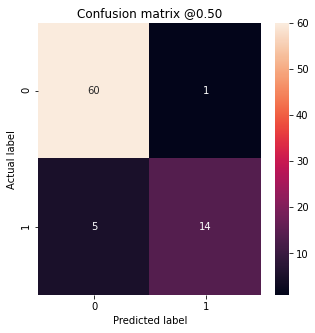

In [74]:
# Take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()

# Retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,xgb_pred)
print("\n")

ROC Curve for the XGBoost Classifier


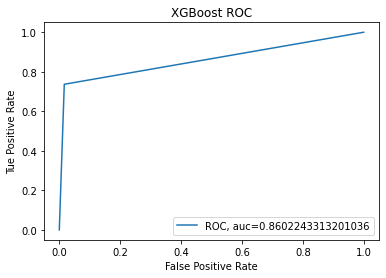

In [75]:
# ROC Curve
print('ROC Curve for the XGBoost Classifier')
roc_maker('XGBoost', xgb_pred, y_test)

In [76]:
#############################################
## Gradient Boosting (Oversampled Dataset) ##
############   Default Params    ############
#############################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_gb = make_imb_pipeline(RandomOverSampler(), GradientBoostingClassifier())

scores_gb_os = cross_validate(oversample_pipe_gb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_gb_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.788346
test_average_precision    0.685620
test_f1                   0.649952
dtype: float64

In [77]:
###############################
## MLP (Oversampled Dataset) ##
####    Default Params     ####
###############################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

oversample_pipe_mlp = make_imb_pipeline(RandomOverSampler(), MLPClassifier())

scores_mlp_os = cross_validate(oversample_pipe_mlp, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_mlp_os)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.773458
test_average_precision    0.641549
test_f1                   0.535389
dtype: float64

## 3. Class Weighting

In [78]:
###########################
## SVC (Class-Weighting) ##
###########################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_SVM_cw = cross_validate(SVC(class_weight='balanced'), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_SVM_cw)[['test_roc_auc', 'test_average_precision', 'test_f1']].mean()

test_roc_auc              0.794252
test_average_precision    0.655600
test_f1                   0.598020
dtype: float64




The best parameters: {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.01}



,Metric,Score
0,F1 Score,0.769231
1,Recall,0.789474
2,Precision,0.750000
3,Accuracy,0.887500
4,AUC ROC,0.853753




True Negatives:  56
False Positives:  5
False Negatives:  4
True Positives:  15
Total:  19




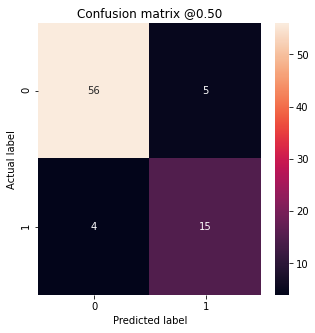

In [79]:
##########################################
##      SVC (Class-Weighted Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
#         'C':[1.0],
        'kernel': ['linear', 'rbf'],
        'degree':[2, 3],
        'gamma': ['scale', 'auto'], #auto_deprecated
        'tol': [0.01, 0.001, 0.0001]
#         'class_weight': ['balanced'],
#         'decision_function_shape': ['ovr'],
#         'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(SVC(class_weight='balanced'), param_grid = param_grid, cv = 3, scoring = scoring)

# Train/fit the model
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)

# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(svc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,svc_pred)
print("\n")

ROC Curve for the SVC


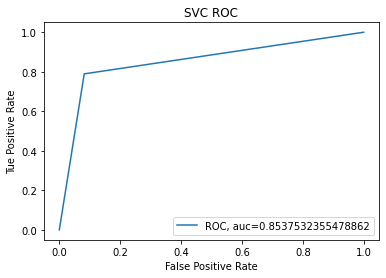

In [80]:
# ROC Curve
print('ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)

In [81]:
######################################
## Decision Trees (Class-Weighting) ## 
######################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_dt_cw = cross_validate(DecisionTreeClassifier(class_weight='balanced'),X_train, y_train, cv = 3, scoring=('roc_auc', 'average_precision', 'f1'))

pd.DataFrame(scores_dt_cw)[['test_roc_auc', 'test_average_precision', 'test_f1']].mean()

test_roc_auc              0.729567
test_average_precision    0.448969
test_f1                   0.585128
dtype: float64




The best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_impurity_decrease': 2.0, 'min_samples_leaf': 0.3, 'splitter': 'best'}



,Metric,Score
0,F1 Score,0.383838
1,Recall,1.000000
2,Precision,0.237500
3,Accuracy,0.237500
4,AUC ROC,0.500000




True Negatives:  0
False Positives:  61
False Negatives:  0
True Positives:  19
Total:  19




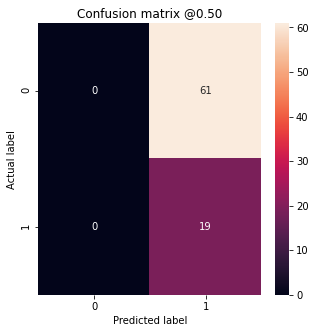

In [82]:
##########################################
## Decision Tree (Class-Weighted Dataset) ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
        'criterion':['gini', 'entropy'],
        'splitter': ['best'],
        'max_depth': [5, 7, None],
#         'min_samples_split':[0.3, 0.4],
        'min_samples_leaf': [0.3, 0.4],
#         'min_weight_fraction_leaf':[0.3, 0.4],
#         'max_features': ['auto', 'sqrt', 'log2'],
        'max_features': ['auto', 'sqrt'],
        'min_impurity_decrease' :[2.0, 3.0],
        }

# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid=param_grid, cv=3, scoring = scoring)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)

# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,dtc_pred)
print("\n")

ROC Curve for the Decision Tree Classifier


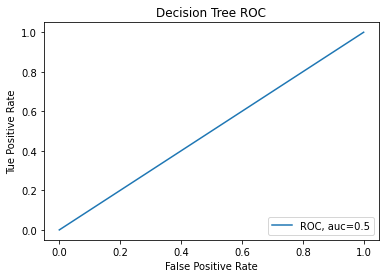

In [83]:
# ROC Curve
print('ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree', dtc_pred, y_test)

In [84]:
######################################
## Random Forests (Class-Weighting) ##
######################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_rf_cw = cross_validate(RandomForestClassifier(class_weight='balanced'), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision', 'f1'))

pd.DataFrame(scores_rf_cw)[['test_roc_auc', 'test_average_precision', 'test_f1']].mean()

test_roc_auc              0.765328
test_average_precision    0.664519
test_f1                   0.335142
dtype: float64

In [85]:
###############################
## XGBoost (Class-Weighting) ##
###############################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

scores_xgb_cw = cross_validate(XGBClassifier(class_weight='balanced'), X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_xgb_cw)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.795077
test_average_precision    0.713670
test_f1                   0.649554
dtype: float64

In [86]:
##########################################
##      XGB (Class-Weighted Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

data = xgb.DMatrix(data=X_train, label=y_train)

xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
#     "early_stopping_rounds": 10,
    "seed": 4060
}

xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)

cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=3, callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(500)])

[0]	train-error:0.76889	test-error:0.76889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 500 rounds.
[1]	train-error:0.76889	test-error:0.76889
[2]	train-error:0.76889	test-error:0.76889
[3]	train-error:0.76889	test-error:0.76889
[4]	train-error:0.76889	test-error:0.76889
[5]	train-error:0.23222	test-error:0.39333
[6]	train-error:0.20111	test-error:0.37333
[7]	train-error:0.10000	test-error:0.23556
[8]	train-error:0.08556	test-error:0.24000
[9]	train-error:0.06222	test-error:0.18667
[10]	train-error:0.05556	test-error:0.16000
[11]	train-error:0.04667	test-error:0.13778
[12]	train-error:0.05222	test-error:0.14444
[13]	train-error:0.05000	test-error:0.13778
[14]	train-error:0.05000	test-error:0.12667
[15]	train-error:0.04778	test-error:0.12444
[16]	train-error:0.05222	test-error:0.12667
[17]	train-error:0.05000	test-error:0.12444
[18]	train-error:0.04889	test-error:0.12444
[19]	train-error:0.05000	tes

[182]	train-error:0.00000	test-error:0.16667
[183]	train-error:0.00000	test-error:0.16222
[184]	train-error:0.00000	test-error:0.16444
[185]	train-error:0.00000	test-error:0.16222
[186]	train-error:0.00000	test-error:0.16667
[187]	train-error:0.00000	test-error:0.16444
[188]	train-error:0.00000	test-error:0.16667
[189]	train-error:0.00000	test-error:0.16444
[190]	train-error:0.00000	test-error:0.16444
[191]	train-error:0.00000	test-error:0.16667
[192]	train-error:0.00000	test-error:0.16444
[193]	train-error:0.00000	test-error:0.16222
[194]	train-error:0.00000	test-error:0.16667
[195]	train-error:0.00000	test-error:0.16222
[196]	train-error:0.00000	test-error:0.16667
[197]	train-error:0.00000	test-error:0.16222
[198]	train-error:0.00000	test-error:0.16667
[199]	train-error:0.00000	test-error:0.16222
[200]	train-error:0.00000	test-error:0.16667
[201]	train-error:0.00000	test-error:0.16222
[202]	train-error:0.00000	test-error:0.16000
[203]	train-error:0.00000	test-error:0.16444
[204]	trai

[365]	train-error:0.00000	test-error:0.16222
[366]	train-error:0.00000	test-error:0.15333
[367]	train-error:0.00000	test-error:0.16222
[368]	train-error:0.00000	test-error:0.15778
[369]	train-error:0.00000	test-error:0.15556
[370]	train-error:0.00000	test-error:0.15556
[371]	train-error:0.00000	test-error:0.15778
[372]	train-error:0.00000	test-error:0.15333
[373]	train-error:0.00000	test-error:0.15778
[374]	train-error:0.00000	test-error:0.15333
[375]	train-error:0.00000	test-error:0.16222
[376]	train-error:0.00000	test-error:0.15333
[377]	train-error:0.00000	test-error:0.16222
[378]	train-error:0.00000	test-error:0.15333
[379]	train-error:0.00000	test-error:0.16222
[380]	train-error:0.00000	test-error:0.15556
[381]	train-error:0.00000	test-error:0.15778
[382]	train-error:0.00000	test-error:0.15556
[383]	train-error:0.00000	test-error:0.15778
[384]	train-error:0.00000	test-error:0.15556
[385]	train-error:0.00000	test-error:0.15778
[386]	train-error:0.00000	test-error:0.15556
[387]	trai

,Metric,Score
0,F1 Score,0.823529
1,Recall,0.736842
2,Precision,0.933333
3,Accuracy,0.925000
4,AUC ROC,0.860224




True Negatives:  60
False Positives:  1
False Negatives:  5
True Positives:  14
Total:  19




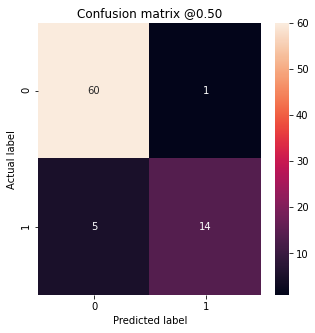

In [87]:
# Take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()

# Retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,xgb_pred)
print("\n")

ROC Curve for the XGBoost Classifier


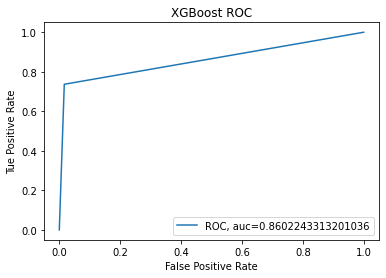

In [88]:
# ROC Curve
print('ROC Curve for the XGBoost Classifier')
roc_maker('XGBoost', xgb_pred, y_test)

## 4. SMOTE (Synthetic Minority Oversampling Technique)

### Add synthetic data to the undersampled class

In [91]:
#################
## SVC (SMOTE) ##
#################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_svc = make_imb_pipeline(SMOTE(), SVC())

scores_svc_smote = cross_validate(smote_pipe_svc, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_svc_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.766526
test_average_precision    0.610426
test_f1                   0.170757
dtype: float64




The best parameters: {'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'linear', 'svc__tol': 0.0001}



,Metric,Score
0,F1 Score,0.800000
1,Recall,0.736842
2,Precision,0.875000
3,Accuracy,0.912500
4,AUC ROC,0.852028




True Negatives:  59
False Positives:  2
False Negatives:  5
True Positives:  14
Total:  19




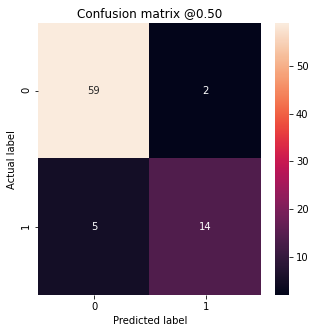

In [92]:
##########################################
##      SVC (SMOTE Dataset)      ##
######       GridSearchCV           ######
##########################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
#         'C':[1.0],
        'svc__kernel': ['linear', 'rbf'],
        'svc__degree':[2, 3],
        'svc__gamma': ['scale', 'auto'], #auto_deprecated
        'svc__tol': [.01, .001, .0001],
#         'class_weight': ['balanced'],
#         'decision_function_shape': ['ovr'],
#         'random_state':[42]
        }
    
# Initialize the classifier with the paramaters and cross validation 
svc_cv = GridSearchCV(smote_pipe_svc, param_grid = param_grid, cv = 3, scoring = scoring)

# Train/fit the model
svc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_svc_cv = svc_cv.best_estimator_
best_svc_cv.fit(X_train, y_train)

# Test Accuracy
svc_pred = best_svc_cv.predict(X_test)
print('\n\n')
print('The best parameters: {}\n'.format(svc_cv.best_params_))

# Print out dataframe of statistics
stat_printer(y_test, svc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,svc_pred)
print("\n")

ROC Curve for the SVC


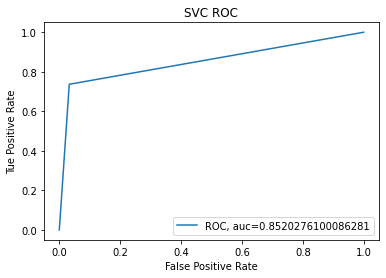

In [93]:
# ROC Curve
print('ROC Curve for the SVC')
roc_maker('SVC', svc_pred, y_test)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.85')

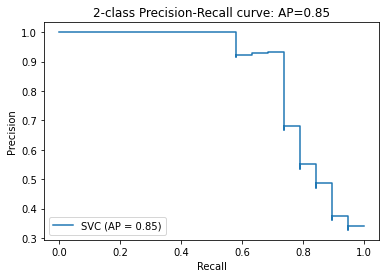

In [94]:
classifier = SVC()
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test) #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

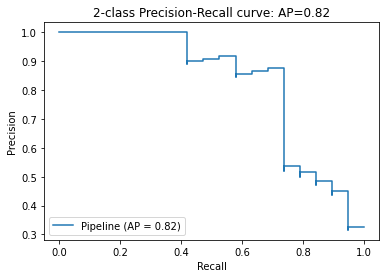

In [95]:
classifier = best_svc_cv
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test) #test_features

average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl

disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

In [96]:
###########################
## Decision Tree (SMOTE) ##
###########################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_dt = make_imb_pipeline(SMOTE(),DecisionTreeClassifier())
                                  
scores_dt_smote = cross_validate(smote_pipe_dt, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_dt_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.664520
test_average_precision    0.366702
test_f1                   0.486550
dtype: float64




The best parameters: {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_impurity_decrease': 2.0, 'decisiontreeclassifier__min_samples_leaf': 0.3, 'decisiontreeclassifier__splitter': 'best'}



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Score
0,F1 Score,0.0000
1,Recall,0.0000
2,Precision,0.0000
3,Accuracy,0.7625
4,AUC ROC,0.5000




True Negatives:  61
False Positives:  0
False Negatives:  19
True Positives:  0
Total:  19




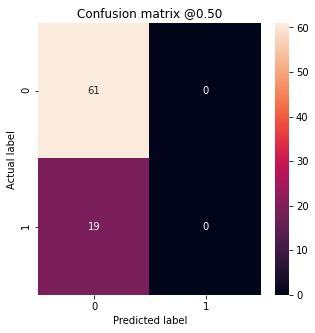

In [97]:
###################################
## Decision Tree (SMOTE Dataset) ##
#########  GridSearchCV   #########
###################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

# Parameter grid
param_grid = {
        'decisiontreeclassifier__criterion':['gini', 'entropy'],
        'decisiontreeclassifier__splitter': ['best'],
        'decisiontreeclassifier__max_depth': [5, 7, None],
#         'min_samples_split':[0.3, 0.4],
        'decisiontreeclassifier__min_samples_leaf': [0.3, 0.4],
#         'min_weight_fraction_leaf':[0.3, 0.4],
#         'max_features': ['auto', 'sqrt', 'log2'],
        'decisiontreeclassifier__max_features': ['auto', 'sqrt'],
        'decisiontreeclassifier__min_impurity_decrease' :[2.0, 3.0],
        }

# Initialize the classifier with the paramaters and cross validation 
dtc_cv = GridSearchCV(smote_pipe_dt, param_grid=param_grid, cv=3, scoring = scoring)

# Train
dtc_cv.fit(X_train, y_train)

# Make predictions on best parameters determined by GridSearchCV
best_dtc_cv = dtc_cv.best_estimator_
best_dtc_cv.fit(X_train, y_train)

# Test Accuracy
dtc_pred = best_dtc_cv.predict(X_test)
print('\n\n')
print(f'The best parameters: {dtc_cv.best_params_}\n')

# Print out dataframe of statistics
stat_printer(y_test, dtc_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,dtc_pred)
print("\n")

ROC Curve for the Decision Tree Classifier


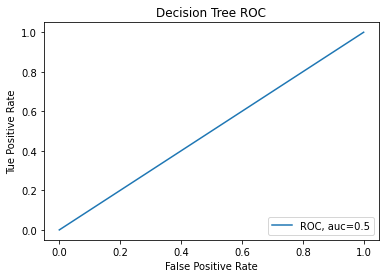

In [98]:
# ROC Curve
print('ROC Curve for the Decision Tree Classifier')
roc_maker('Decision Tree', dtc_pred, y_test)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.53')

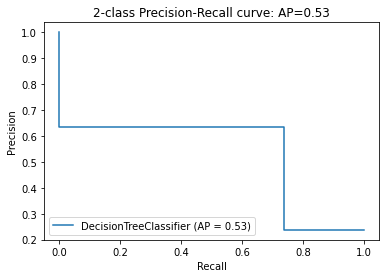

In [99]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.24')

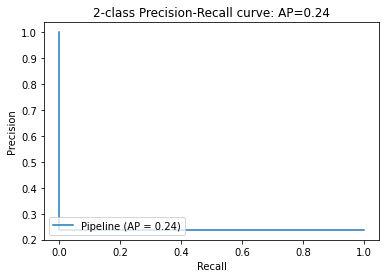

In [100]:
classifier = best_dtc_cv
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features

average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl

disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

In [101]:
###########################
## Random Forest (SMOTE) ##
###########################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier())

scores_rf_smote = cross_validate(smote_pipe_rf, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_rf_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.773639
test_average_precision    0.594139
test_f1                   0.276264
dtype: float64

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.87')

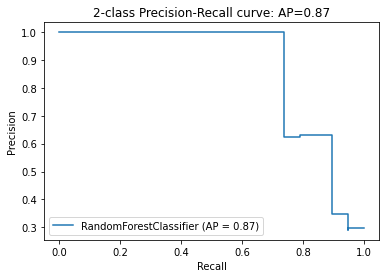

In [102]:
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

In [103]:
#####################
## XGBoost (SMOTE) ##
#####################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_xgb = make_imb_pipeline(SMOTE(), XGBClassifier())

scores_xgb_smote = cross_validate(smote_pipe_xgb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_xgb_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.793411
test_average_precision    0.708621
test_f1                   0.626810
dtype: float64

In [104]:
###################################
##      XGB (SMOTE Dataset)      ##
######      GridSearchCV    #######
###################################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

data = xgb.DMatrix(data=X_train, label=y_train)

xgb_params = {
    "eta": 0.1,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "binary:hinge", #This is the objective used to perform binary classification
    "eval_metric": "error",
#     "early_stopping_rounds": 10,
    "seed": 4060
}

xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=1000)

cv_history = xgb.cv(params=xgb_params, dtrain=data, num_boost_round=1000, nfold=3, callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(500)])

[0]	train-error:0.76889	test-error:0.76889
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 500 rounds.
[1]	train-error:0.76889	test-error:0.76889
[2]	train-error:0.76889	test-error:0.76889
[3]	train-error:0.76889	test-error:0.76889
[4]	train-error:0.76889	test-error:0.76889
[5]	train-error:0.23222	test-error:0.39333
[6]	train-error:0.20111	test-error:0.37333
[7]	train-error:0.10000	test-error:0.23556
[8]	train-error:0.08556	test-error:0.24000
[9]	train-error:0.06222	test-error:0.18667
[10]	train-error:0.05556	test-error:0.16000
[11]	train-error:0.04667	test-error:0.13778
[12]	train-error:0.05222	test-error:0.14444
[13]	train-error:0.05000	test-error:0.13778
[14]	train-error:0.05000	test-error:0.12667
[15]	train-error:0.04778	test-error:0.12444
[16]	train-error:0.05222	test-error:0.12667
[17]	train-error:0.05000	test-error:0.12444
[18]	train-error:0.04889	test-error:0.12444
[19]	train-error:0.05000	tes

[182]	train-error:0.00000	test-error:0.16667
[183]	train-error:0.00000	test-error:0.16222
[184]	train-error:0.00000	test-error:0.16444
[185]	train-error:0.00000	test-error:0.16222
[186]	train-error:0.00000	test-error:0.16667
[187]	train-error:0.00000	test-error:0.16444
[188]	train-error:0.00000	test-error:0.16667
[189]	train-error:0.00000	test-error:0.16444
[190]	train-error:0.00000	test-error:0.16444
[191]	train-error:0.00000	test-error:0.16667
[192]	train-error:0.00000	test-error:0.16444
[193]	train-error:0.00000	test-error:0.16222
[194]	train-error:0.00000	test-error:0.16667
[195]	train-error:0.00000	test-error:0.16222
[196]	train-error:0.00000	test-error:0.16667
[197]	train-error:0.00000	test-error:0.16222
[198]	train-error:0.00000	test-error:0.16667
[199]	train-error:0.00000	test-error:0.16222
[200]	train-error:0.00000	test-error:0.16667
[201]	train-error:0.00000	test-error:0.16222
[202]	train-error:0.00000	test-error:0.16000
[203]	train-error:0.00000	test-error:0.16444
[204]	trai

[365]	train-error:0.00000	test-error:0.16222
[366]	train-error:0.00000	test-error:0.15333
[367]	train-error:0.00000	test-error:0.16222
[368]	train-error:0.00000	test-error:0.15778
[369]	train-error:0.00000	test-error:0.15556
[370]	train-error:0.00000	test-error:0.15556
[371]	train-error:0.00000	test-error:0.15778
[372]	train-error:0.00000	test-error:0.15333
[373]	train-error:0.00000	test-error:0.15778
[374]	train-error:0.00000	test-error:0.15333
[375]	train-error:0.00000	test-error:0.16222
[376]	train-error:0.00000	test-error:0.15333
[377]	train-error:0.00000	test-error:0.16222
[378]	train-error:0.00000	test-error:0.15333
[379]	train-error:0.00000	test-error:0.16222
[380]	train-error:0.00000	test-error:0.15556
[381]	train-error:0.00000	test-error:0.15778
[382]	train-error:0.00000	test-error:0.15556
[383]	train-error:0.00000	test-error:0.15778
[384]	train-error:0.00000	test-error:0.15556
[385]	train-error:0.00000	test-error:0.15778
[386]	train-error:0.00000	test-error:0.15556
[387]	trai

,Metric,Score
0,F1 Score,0.823529
1,Recall,0.736842
2,Precision,0.933333
3,Accuracy,0.925000
4,AUC ROC,0.860224




True Negatives:  60
False Positives:  1
False Negatives:  5
True Positives:  14
Total:  19




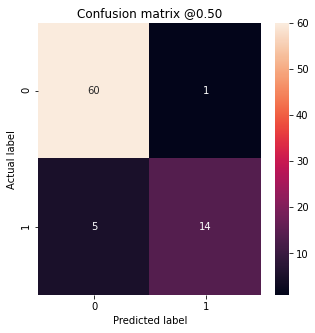

In [105]:
# Take the best iteration 
best_iter = cv_history["test-error-mean"].idxmin()

# Retrain based on the best iteration
xgbmodel = xgb.train(params=xgb_params, dtrain=data, num_boost_round=best_iter)

#Let's do a prediction
xgb_pred = xgbmodel.predict(xgb.DMatrix(X_test))

# Print out dataframe of statistics
stat_printer(y_test, xgb_pred)
print("\n")

#Confusion Matrix
plot_cm(y_test,xgb_pred)
print("\n")

ROC Curve for the XGBoost Classifier


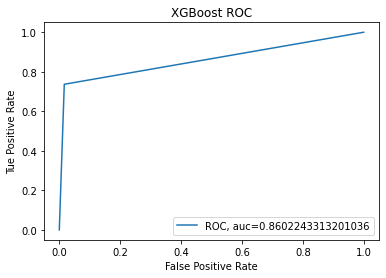

In [106]:
# ROC Curve
print('ROC Curve for the XGBoost Classifier')
roc_maker('XGBoost', xgb_pred, y_test)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.87')

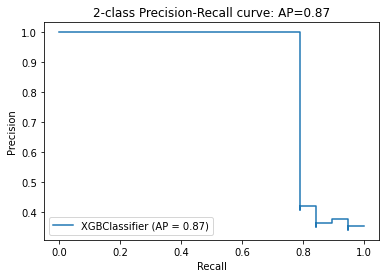

In [107]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

In [108]:
y_score = xgb_pred #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
average_precision

0.750219298245614

In [109]:
###############################
## Gradient Boosting (SMOTE) ##
###############################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_gb = make_imb_pipeline(SMOTE(), GradientBoostingClassifier())

scores_gb_smote = cross_validate(smote_pipe_gb, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_gb_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.779280
test_average_precision    0.690875
test_f1                   0.604832
dtype: float64

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82')

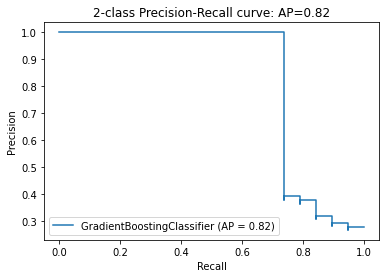

In [110]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

In [111]:
#################
## MLP (SMOTE) ##
#################

##############################################
### Stratified K-Fold (3) Cross Validation ###
##############################################

smote_pipe_mlp = make_imb_pipeline(SMOTE(), MLPClassifier())

scores_mlp_smote = cross_validate(smote_pipe_mlp, X_train, y_train, cv=3, scoring=('roc_auc', 'average_precision','f1'))

pd.DataFrame(scores_mlp_smote)[['test_roc_auc', 'test_average_precision','test_f1']].mean()

test_roc_auc              0.756293
test_average_precision    0.607484
test_f1                   0.477132
dtype: float64

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

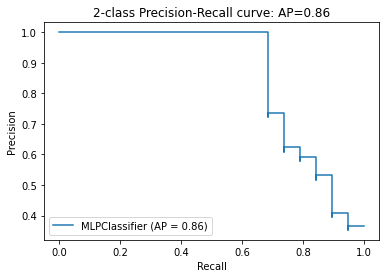

In [112]:
classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:,1] #test_features
average_precision = average_precision_score(y_test, y_score) # y_test might be test_labesl
disp = plot_precision_recall_curve(classifier, X_test, y_test) #test_features, test_labels
disp.ax_.set_title('2-class Precision-Recall curve: ''AP={0:0.2f}'.format(average_precision))

## Neural Network Model with Tensorflow and Keras

In [248]:
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
526,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
527,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
528,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [249]:
y

0      1
1      1
2      1
3      1
4      1
      ..
525    0
526    0
527    0
528    0
529    0
Name: response, Length: 530, dtype: int64

In [250]:
# Read the data (.txt file and create dataframe with features/predictors and response/labels)
text = pd.read_csv("DScasestudy_(1).txt", delimiter = "\t")
df = pd.DataFrame(data = text)
df

,response,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
526,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
527,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
528,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [251]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('response'))
val_labels = np.array(val_df.pop('response'))
test_labels = np.array(test_df.pop('response'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape: {}'.format(train_labels.shape))
print('Validation labels shape:', val_labels.shape)
print('Test labels shape: {} \n'.format(test_labels.shape))

print('Training features shape: {}'.format(train_features.shape))
print('Validation features shape:', val_features.shape)
print('Test features shape: {} \n'.format(test_features.shape))

print('Number of train examples: {}'.format(len(train_df)))
print('Number of validation examples: {}'.format(len(val_df)))
print('Number of test examples: {}'.format(len(test_df)))

Training labels shape: (339,)
Validation labels shape: (85,)
Test labels shape: (106,) 

Training features shape: (339, 16562)
Validation features shape: (85, 16562)
Test features shape: (106, 16562) 

Number of train examples: 339
Number of validation examples: 85
Number of test examples: 106


## Define Model and Metrics

### Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns a probability


In [252]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([
          keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
          keras.layers.Dense(16, activation='relu'),
          keras.layers.Dense(16, activation='relu'),
#           keras.layers.Dense(16, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
      ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

## Baseline Model

### Make sure the batch size is large enough to contain samples from the under-represented class

In [253]:
EPOCHS = 100
BATCH_SIZE = 8 # 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [254]:
model = make_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 16)                265008    
_________________________________________________________________
dense_71 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_72 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 17        
Total params: 265,569
Trainable params: 265,569
Non-trainable params: 0
_________________________________________________________________


In [255]:
model.predict(train_features[:10])

array([[0.53235936],
       [0.5614389 ],
       [0.49301553],
       [0.59025913],
       [0.5691613 ],
       [0.5810863 ],
       [0.6076458 ],
       [0.5806434 ],
       [0.60041535],
       [0.5729823 ]], dtype=float32)

In [256]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7782


In [257]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.19662883])

In [258]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.21594647],
       [0.20950465],
       [0.22128084],
       [0.19598718],
       [0.21749052],
       [0.21579932],
       [0.20573546],
       [0.20741472],
       [0.2229426 ],
       [0.250751  ]], dtype=float32)

In [259]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5306


## Checkpoint the Initial Weights

In [260]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

## Train the Model

In [261]:
model = make_model()
# model = make_model(output_bias = initial_bias)
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 339 samples, validate on 85 samples
Epoch 1/100
339/339 [==============================] - 3s 8ms/sample - loss: 0.5291 - tp: 3.0000 - fp: 1.0000 - tn: 262.0000 - fn: 73.0000 - accuracy: 0.7817 - precision: 0.7500 - recall: 0.0395 - auc: 0.5473 - val_loss: 0.5161 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 62.0000 - val_fn: 20.0000 - val_accuracy: 0.7647 - val_precision: 1.0000 - val_recall: 0.1304 - val_auc: 0.7514
Epoch 2/100
339/339 [==============================] - 0s 625us/sample - loss: 0.4317 - tp: 26.0000 - fp: 6.0000 - tn: 257.0000 - fn: 50.0000 - accuracy: 0.8348 - precision: 0.8125 - recall: 0.3421 - auc: 0.7504 - val_loss: 0.5022 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 62.0000 - val_fn: 20.0000 - val_accuracy: 0.7647 - val_precision: 1.0000 - val_recall: 0.1304 - val_auc: 0.7763
Epoch 3/100
339/339 [==============================] - 0s 718us/sample - loss: 0.3579 - tp: 34.0000 - fp: 6.0000 - tn: 257.0000 - fn: 42.0000 - accuracy: 0.8584 - precision: 0.

## Check the training history

In [262]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

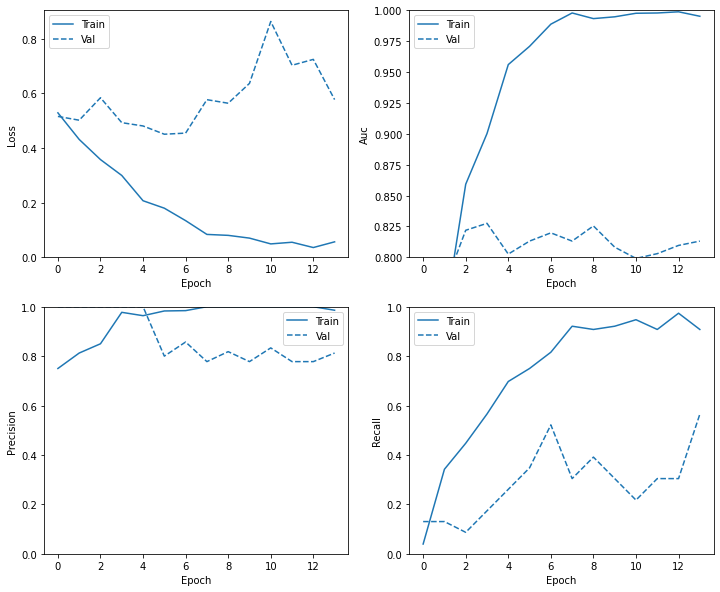

In [263]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_metrics(baseline_history)

## Evaluation Metrics

In [264]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.3631214551487059
tp :  12.0
fp :  1.0
tn :  81.0
fn :  12.0
accuracy :  0.8773585
precision :  0.9230769
recall :  0.5
auc :  0.8460366

True Negatives:  81
False Positives:  1
False Negatives:  12
True Positives:  12
Total:  24


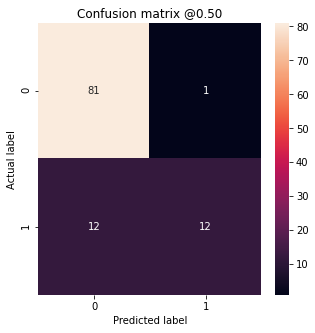

In [265]:
## Evaluate on test dataset and display results for metrics
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. 
In this case the matrix shows **TALK ABOUT ASYMMETRIC/SYMMETRIC COSTS**

In [266]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

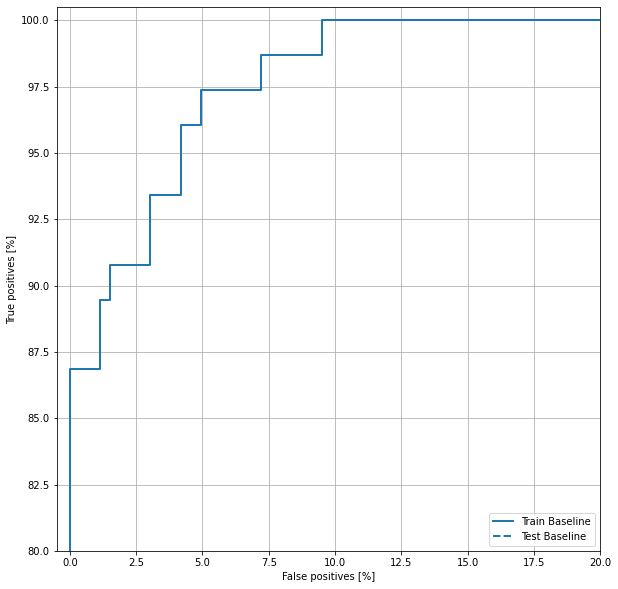

In [267]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Class Weighting

In [268]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.65
Weight for class 1: 2.15


In [269]:
weighted_model = make_model() # make_model(output_bias = initial_bias) # make_model() or model previously defined as model_c
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Train on 339 samples, validate on 85 samples
Epoch 1/100
339/339 [==============================] - 3s 9ms/sample - loss: 0.8641 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 263.0000 - fn: 76.0000 - accuracy: 0.7758 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5020 - val_loss: 0.9280 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 62.0000 - val_fn: 23.0000 - val_accuracy: 0.7294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6069
Epoch 2/100
339/339 [==============================] - 0s 627us/sample - loss: 0.7689 - tp: 4.0000 - fp: 16.0000 - tn: 247.0000 - fn: 72.0000 - accuracy: 0.7404 - precision: 0.2000 - recall: 0.0526 - auc: 0.4754 - val_loss: 0.7641 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 62.0000 - val_fn: 23.0000 - val_accuracy: 0.7294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7044
Epoch 3/100
339/339 [==============================] - 0s 646us/sample - loss: 0.6830 - tp: 22.0000 - fp: 30.0000 - tn: 233.0000 - fn: 5

Epoch 22/100
339/339 [==============================] - 0s 611us/sample - loss: 0.0995 - tp: 67.0000 - fp: 0.0000e+00 - tn: 263.0000 - fn: 9.0000 - accuracy: 0.9735 - precision: 1.0000 - recall: 0.8816 - auc: 0.9958 - val_loss: 1.8665 - val_tp: 7.0000 - val_fp: 2.0000 - val_tn: 60.0000 - val_fn: 16.0000 - val_accuracy: 0.7882 - val_precision: 0.7778 - val_recall: 0.3043 - val_auc: 0.7763
Epoch 00022: early stopping


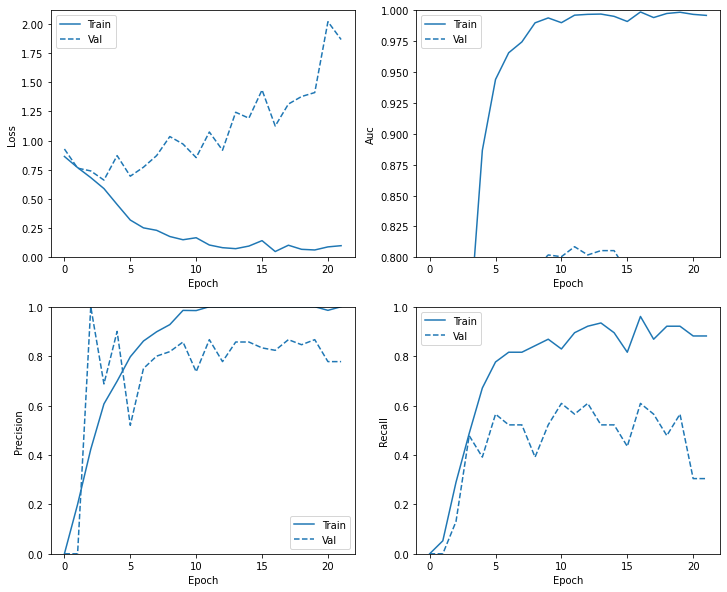

In [270]:
plot_metrics(weighted_history)

loss :  0.3889116791059386
tp :  16.0
fp :  5.0
tn :  77.0
fn :  8.0
accuracy :  0.8773585
precision :  0.7619048
recall :  0.6666667
auc :  0.85772365

True Negatives:  77
False Positives:  5
False Negatives:  8
True Positives:  16
Total:  24


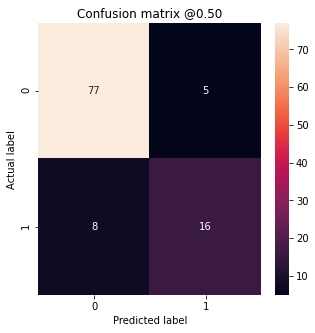

In [271]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

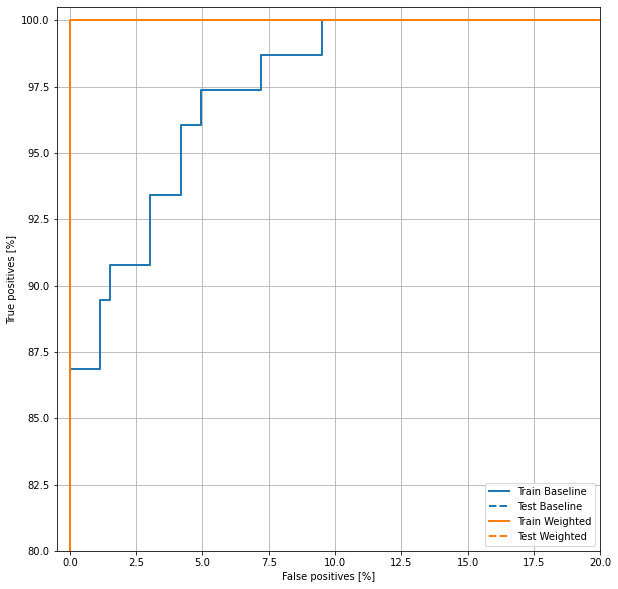

In [272]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle = '--')

plt.legend(loc='lower right')

## Oversampling

In [274]:
bool_train_labels = train_labels != 0

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [275]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(263, 16562)

In [276]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(526, 16562)

In [277]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [278]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [0 0 0 ... 0 0 0]

Label:  1


In [279]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [280]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.375


In [281]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

102.0

## Train on oversampled data

In [282]:
resampled_model = make_model() # make_model(output_bias = initial_bias) # model or make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 102.0 steps, validate for 11 steps
Epoch 1/100
102/102 [==============================] - 3s 31ms/step - loss: 0.7127 - tp: 178.0000 - fp: 175.0000 - tn: 233.0000 - fn: 230.0000 - accuracy: 0.5037 - precision: 0.5042 - recall: 0.4363 - auc: 0.5098 - val_loss: 0.6721 - val_tp: 15.0000 - val_fp: 17.0000 - val_tn: 45.0000 - val_fn: 8.0000 - val_accuracy: 0.7059 - val_precision: 0.4688 - val_recall: 0.6522 - val_auc: 0.7216
Epoch 2/100
102/102 [==============================] - 0s 5ms/step - loss: 0.5113 - tp: 316.0000 - fp: 119.0000 - tn: 282.0000 - fn: 99.0000 - accuracy: 0.7328 - precision: 0.7264 - recall: 0.7614 - auc: 0.8221 - val_loss: 0.4639 - val_tp: 16.0000 - val_fp: 9.0000 - val_tn: 53.0000 - val_fn: 7.0000 - val_accuracy: 0.8118 - val_precision: 0.6400 - val_recall: 0.6957 - val_auc: 0.7977
Epoch 3/100
102/102 [==============================] - 0s 4ms/step - loss: 0.2097 - tp: 378.0000 - fp: 30.0000 - tn: 382.0000 - fn: 26.0000 - accuracy: 0.9314 - precision: 0.9265 -

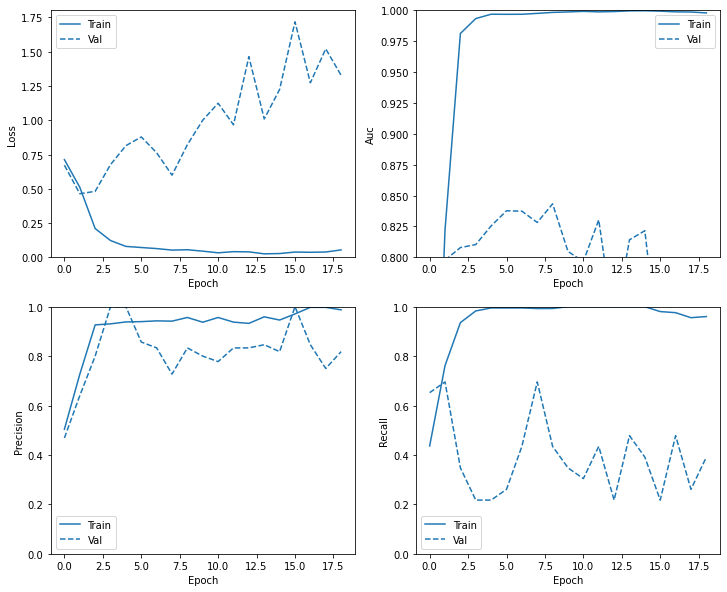

In [283]:
plot_metrics(resampled_history )

## Retrain

In [284]:
resampled_model = make_model() #make_model(output_bias = initial_bias) # model or make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 11 steps
Epoch 1/1000
20/20 [==============================] - 3s 139ms/step - loss: 0.6894 - tp: 20.0000 - fp: 21.0000 - tn: 71.0000 - fn: 48.0000 - accuracy: 0.5688 - precision: 0.4878 - recall: 0.2941 - auc: 0.5827 - val_loss: 0.5649 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 62.0000 - val_fn: 23.0000 - val_accuracy: 0.7294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8082
Epoch 2/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.7047 - tp: 15.0000 - fp: 11.0000 - tn: 74.0000 - fn: 60.0000 - accuracy: 0.5562 - precision: 0.5769 - recall: 0.2000 - auc: 0.5747 - val_loss: 0.6089 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 61.0000 - val_fn: 21.0000 - val_accuracy: 0.7412 - val_precision: 0.6667 - val_recall: 0.0870 - val_auc: 0.7525
Epoch 3/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.6597 - tp: 33.0000 - fp: 9.0000 - tn: 60.0000 - fn: 58.0000 - accuracy: 0.5813 - precision: 0.7857 -

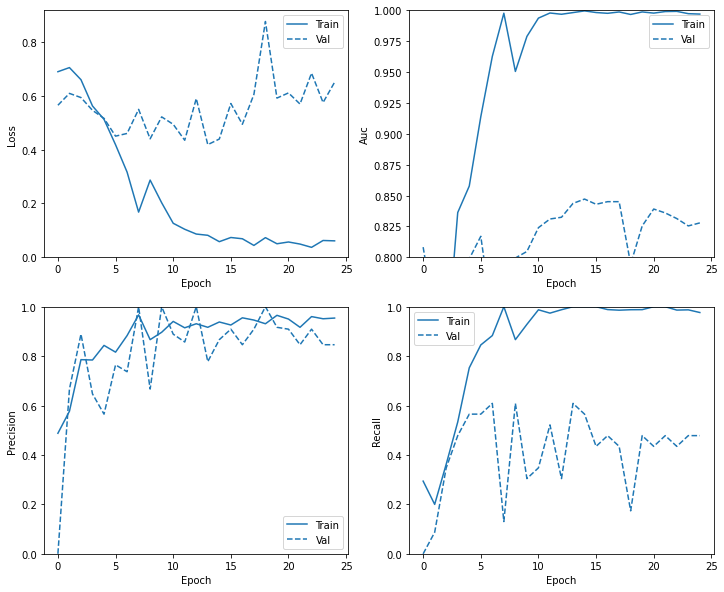

In [285]:
plot_metrics(resampled_history)

## Evalutation Metrics

In [286]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.39316379405417534
tp :  16.0
fp :  6.0
tn :  76.0
fn :  8.0
accuracy :  0.8679245
precision :  0.72727275
recall :  0.6666667
auc :  0.8694106

True Negatives:  76
False Positives:  6
False Negatives:  8
True Positives:  16
Total:  24


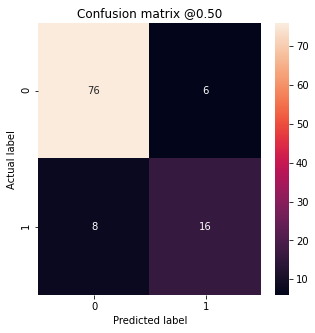

In [287]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

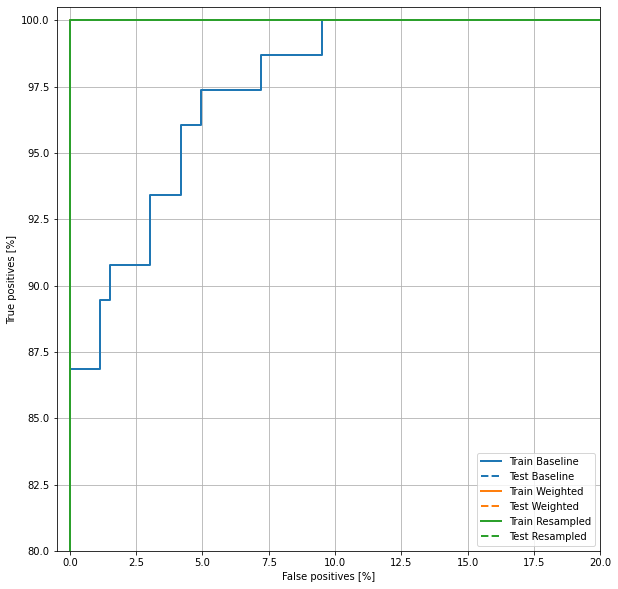

In [288]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')

plt.legend(loc='lower right')